In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""import os
import gdown

os.makedirs('./saved_models/u2net', exist_ok=True)
os.makedirs('./saved_models/u2net_portrait', exist_ok=True)

gdown.download('https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ',
    './saved_models/u2net/u2net.pth',
    quiet=False)

gdown.download('https://drive.google.com/uc?id=1IG3HdpcRiDoWNookbncQjeaPN28t90yW',
    './saved_models/u2net_portrait/u2net_portrait.pth',
    quiet=False)"""

"import os\nimport gdown\n\nos.makedirs('./saved_models/u2net', exist_ok=True)\nos.makedirs('./saved_models/u2net_portrait', exist_ok=True)\n\ngdown.download('https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ',\n    './saved_models/u2net/u2net.pth',\n    quiet=False)\n\ngdown.download('https://drive.google.com/uc?id=1IG3HdpcRiDoWNookbncQjeaPN28t90yW',\n    './saved_models/u2net_portrait/u2net_portrait.pth',\n    quiet=False)"

In [ ]:
# u2net_path = "/content/saved_models/u2net/u2net.pth"

In [ ]:
# Laura
# renders_file_path = "/content/drive/MyDrive/INSA/5A /ProjetRI/renders4s"

# output_file_path = "/content/drive/MyDrive/INSA/5A /ProjetRI/outputs"

# Vilde
renders_file_path = "/content/drive/MyDrive/ProjetRI/renders7train"

test_renders_file_path = "/content/drive/MyDrive/ProjetRI/renders6test"

#output_file_path = "/content/drive/MyDrive/ProjetRI/outputs"

#Scratch
#renders_file_path = "./renders4s"

#output_file_path = "./outputs"


In [ ]:
#!mkdir renders

In [ ]:
#!cp -r "/content/drive/MyDrive/INSA/5A /ProjetRI/renders4s" "/content/renders"

^C


In [ ]:
import os
import torch
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms
#!cp -r "/content/drive/MyDrive/ProjetRI/u2net.py" "/content/" # Vilde
#from u2net import U2NET  # Ensure this is the correct path to the U2-Net model definition
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
import pandas as pd


In [ ]:
#!ls "/content/drive/MyDrive/INSA/5A /ProjetRI/renders4s/caf076c38cd84322b61f49a91eafe136/depth_caf076c38cd84322b61f49a91eafe136_fireplace_4k.exr_./hdris/fireplace_4k.exr_00006.png"

fireplace_4k.exr_0000.png  fireplace_4k.exr_0004.png  fireplace_4k.exr_0008.png
fireplace_4k.exr_0001.png  fireplace_4k.exr_0005.png  fireplace_4k.exr_0009.png
fireplace_4k.exr_0002.png  fireplace_4k.exr_0006.png
fireplace_4k.exr_0003.png  fireplace_4k.exr_0007.png


In [ ]:
#!find /content/drive/MyDrive/ProjetRI/renders4s -mindepth 1 -maxdepth 1 -type d | wc -l


100


In [ ]:
def replace_second_occurrence(text, old, new):
    """Replaces only the second occurrence of `old` with `new` in `text`."""
    first_index = text.find(old)
    if first_index == -1:
        return text  # No occurrence found

    second_index = text.find(old, first_index + 1)
    if second_index == -1:
        return text  # Only one occurrence found

    return text[:second_index] + new + text[second_index + len(old):]

def remove_leading_zero_in_filename(filepath):
    """Remove one leading zero in the last part of the filename before the extension."""
    # Find the last underscore before the extension
    last_underscore_index = filepath.rfind('_')
    if last_underscore_index == -1:
        return filepath  # No underscore found

    # Check if the part after the last underscore has a leading zero
    last_part = filepath[last_underscore_index + 1:]
    if last_part.startswith("0"):# and last_part[1:].isdigit():
        # Remove the leading zero
        filepath = filepath[:last_underscore_index + 1] + last_part[1:]

    return filepath

In [ ]:
# Without dobbels
image_folder = renders_file_path  # Ensure renders_file_path is defined
image_data = []
for scene_name in os.listdir(image_folder):
    scene_path = os.path.join(image_folder, scene_name)

    if not os.path.isdir(scene_path):
        continue

    render_dir = None

    for subfolder in os.listdir(scene_path):
        if subfolder.startswith("render"):
            render_dir = os.path.join(scene_path, subfolder, "hdris")
            #break  # Process only the first valid render_dir

        if render_dir and os.path.exists(render_dir):
            render_files = sorted(os.listdir(render_dir))

            for render_file in render_files:
                render_path = os.path.join(render_dir, render_file)

                depth_path = replace_second_occurrence(render_path, "render", "seg") #changed for seg
                depth_path = remove_leading_zero_in_filename(depth_path)

                if os.path.exists(depth_path):
                    pair = {'filename': render_path, 'label': depth_path}
                    if pair not in image_data:
                        image_data.append(pair)
                    #else:
                        #print(f"Duplicate pair skipped: {pair}")
                else:
                    print(f"Depth file not found: {depth_path}")

print(f"Collected {len(image_data)} correctly paired image-depth pairs.")

Collected 1473 correctly paired image-depth pairs.


In [ ]:
len(image_data)

1473

In [ ]:
df = pd.DataFrame(image_data)


In [ ]:
df

,filename,label
0,/content/drive/MyDrive/ProjetRI/renders4s/bf0f...,/content/drive/MyDrive/ProjetRI/renders4s/bf0f...
1,/content/drive/MyDrive/ProjetRI/renders4s/bf0f...,/content/drive/MyDrive/ProjetRI/renders4s/bf0f...
2,/content/drive/MyDrive/ProjetRI/renders4s/bf0f...,/content/drive/MyDrive/ProjetRI/renders4s/bf0f...
3,/content/drive/MyDrive/ProjetRI/renders4s/bf0f...,/content/drive/MyDrive/ProjetRI/renders4s/bf0f...
4,/content/drive/MyDrive/ProjetRI/renders4s/bf0f...,/content/drive/MyDrive/ProjetRI/renders4s/bf0f...
...,...,...
9995,/content/drive/MyDrive/ProjetRI/renders4s/04c1...,/content/drive/MyDrive/ProjetRI/renders4s/04c1...
9996,/content/drive/MyDrive/ProjetRI/renders4s/04c1...,/content/drive/MyDrive/ProjetRI/renders4s/04c1...
9997,/content/drive/MyDrive/ProjetRI/renders4s/04c1...,/content/drive/MyDrive/ProjetRI/renders4s/04c1...
9998,/content/drive/MyDrive/ProjetRI/renders4s/04c1...,/content/drive/MyDrive/ProjetRI/renders4s/04c1...


In [ ]:
# Checking for duplicates
duplicates = df.duplicated()
print("Number of duplicates:",sum(duplicates))
print("Length of dataset:",len(df))

Number of duplicates: 0
Length of dataset: 1473


#Data processing


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import torchvision.transforms as transforms

class ImageDepthDataset(Dataset):
    def __init__(self, dataframe, img_transform=None, threshold=0.5):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with two columns: 'image_path' and 'depth_path'.
            img_transform (callable, optional): Optional transform to be applied to the images.
            threshold (float): Value between 0 and 1 to convert depth maps into binary masks.
        """
        self.dataframe = dataframe
        self.img_transform = img_transform
        self.threshold = threshold  # Threshold for binary mask

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image and depth map paths
        img_path = self.dataframe.iloc[idx, 0]
        depth_path = self.dataframe.iloc[idx, 1]

        # Open image and depth map
        image = Image.open(img_path).convert("RGB")  # Convert to RGB
        depth_map = Image.open(depth_path).convert("L")  # Convert depth map to grayscale

        # Apply image transformation
        if self.img_transform:
            image = self.img_transform(image)

        # Convert depth map to tensor
        depth_tensor = transforms.ToTensor()(depth_map)  # Convert to [1, H, W]

        # Convert depth map to binary mask using the threshold
        binary_mask = (depth_tensor > self.threshold).float()  # Thresholding

        return image, binary_mask



In [ ]:
# Example Usage
img_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = ImageDepthDataset(df, img_transform=img_transform, threshold=0.5)
dataloader = torch.utils.data.DataLoader(dataset, batch_size= 3, shuffle=True) # batch_size=8

# Get a batch
#images, masks = next(iter(dataloader))
#print(images.shape, masks.shape)

NameError: name 'df' is not defined

## Visualisation

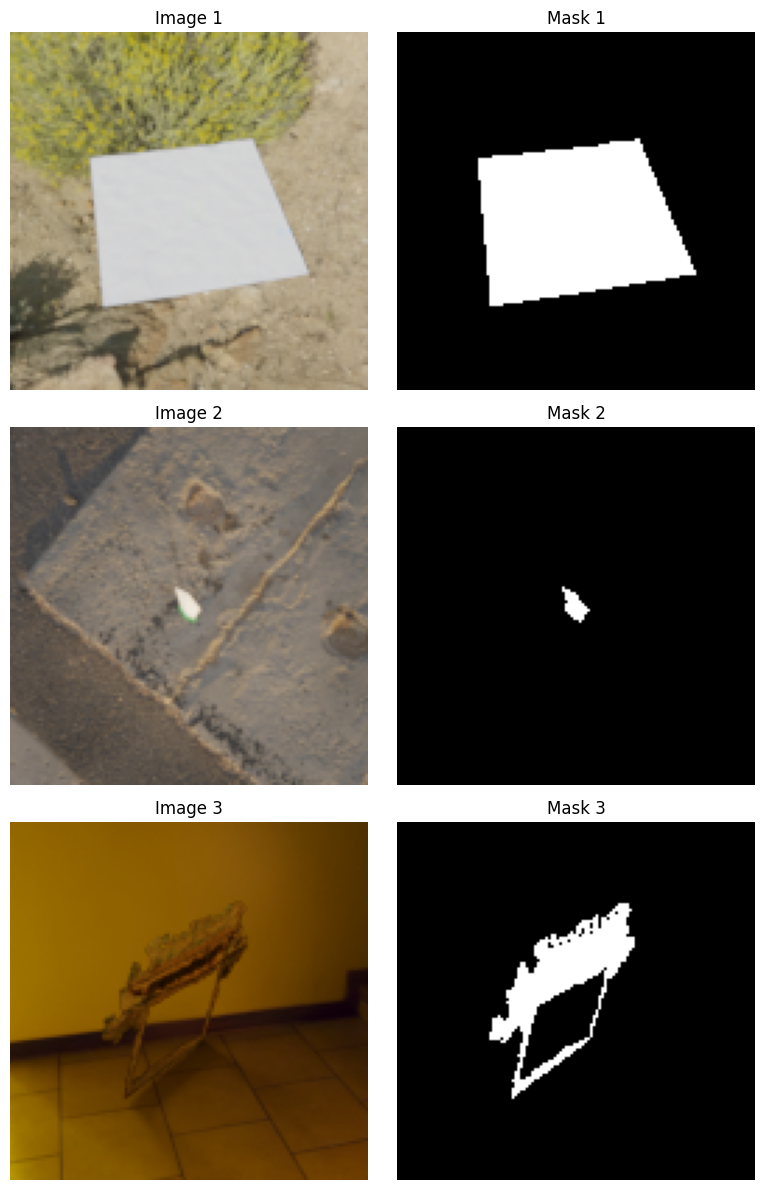

In [ ]:
# Get a batch of images and masks
images, masks = next(iter(dataloader))

# Number of examples to display
num_examples = 3

# Create subplots
fig, axes = plt.subplots(num_examples, 2, figsize=(8, 4 * num_examples))

for i in range(num_examples):
    # Plot image
    axes[i, 0].imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    axes[i, 0].set_title(f"Image {i+1}")
    axes[i, 0].axis("off")

    # Plot mask
    axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')  # Assuming mask is single-channel
    axes[i, 1].set_title(f"Mask {i+1}")
    axes[i, 1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

# The UNet model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = self.upconv(1024, 512)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = self.upconv(512, 256)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = self.upconv(256, 128)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = self.upconv(128, 64)
        self.dec1 = self.conv_block(128, 64)

        # Final output layer
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)  # Output 1 channel for binary mask

    def conv_block(self, in_channels, out_channels):
        """Two Convolutional layers with BatchNorm and ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def upconv(self, in_channels, out_channels):
        """Upsampling using Transposed Convolution"""
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, kernel_size=2))
        e3 = self.enc3(F.max_pool2d(e2, kernel_size=2))
        e4 = self.enc4(F.max_pool2d(e3, kernel_size=2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, kernel_size=2))

        # Decoder path
        d4 = self.upconv4(b)
        d4 = torch.cat((e4, d4), dim=1)  # Skip connection
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        # Final output layer
        output = torch.sigmoid(self.final_conv(d1))  # Sigmoid for binary classification
        return output

# Example usage
model = UNet()
# print(model)


In [ ]:
# Example Usage
img_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = ImageDepthDataset(df, img_transform=img_transform, threshold=0.5)
dataloader = torch.utils.data.DataLoader(dataset, batch_size= 32, shuffle=True) # batch_size=8

NameError: name 'df' is not defined

In [ ]:
import torch.optim as optim

# Loss function (Binary Cross Entropy)
criterion = nn.BCELoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified)
def train_model(model, dataloader, num_epochs=10, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            preds = model(images)
            loss = criterion(preds, masks)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}")

# Training the model
# train_model(model, dataloader, num_epochs=10)


Epoch 1/10, Loss: 0.4452939047790564
Epoch 2/10, Loss: 0.34620904075071074


In [ ]:
#torch.save(model.state_dict(), '/content/drive/MyDrive/ProjetRI/model.pth')
# torch.save(model.state_dict(), 'model.pth')

## Uploading the model weights

In [ ]:
#Uploading the model weights

# Instantiate the UNet model
model = UNet()

# Load the saved state_dict
state_dict = torch.load('/content/drive/MyDrive/ProjetRI/model_seg.pth')  # Update with the actual path

# Load weights into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode for inference
model.eval()

# Move the model to the appropriate device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


<ipython-input-9-944a437e3585>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/ProjetRI/model_seg.pth')  # Update with the a

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

# Testing with the test dataset

In [ ]:
# Without dobbels TEST SET
image_folder = test_renders_file_path
test_data = []
for scene_name in os.listdir(image_folder):
    scene_path = os.path.join(image_folder, scene_name)

    if not os.path.isdir(scene_path):
        continue

    render_dir = None

    for subfolder in os.listdir(scene_path):
        if subfolder.startswith("render"):
            render_dir = os.path.join(scene_path, subfolder, "hdris")
            #break  # Process only the first valid render_dir

        if render_dir and os.path.exists(render_dir):
            render_files = sorted(os.listdir(render_dir))

            for render_file in render_files:
                render_path = os.path.join(render_dir, render_file)

                depth_path = replace_second_occurrence(render_path, "render", "seg")
                depth_path = remove_leading_zero_in_filename(depth_path)

                if os.path.exists(depth_path):
                    pair = {'filename': render_path, 'label': depth_path}
                    if pair not in test_data:
                        test_data.append(pair)
                    #else:
                        #print(f"Duplicate pair skipped: {pair}")
                else:
                    print(f"Depth file not found: {depth_path}")

print(f"Collected {len(test_data)} correctly paired image-depth pairs.")

Collected 1473 correctly paired image-depth pairs.


In [ ]:
test_df = pd.DataFrame(test_data)

In [ ]:
# Checking for duplicates
duplicates = test_df.duplicated()
print("Number of duplicates:",sum(duplicates))
print("Length of dataset:",len(test_df))

Number of duplicates: 0
Length of dataset: 1473


In [ ]:
test_df

,filename,label
0,/content/drive/MyDrive/ProjetRI/renders6test/1...,/content/drive/MyDrive/ProjetRI/renders6test/1...
1,/content/drive/MyDrive/ProjetRI/renders6test/1...,/content/drive/MyDrive/ProjetRI/renders6test/1...
2,/content/drive/MyDrive/ProjetRI/renders6test/1...,/content/drive/MyDrive/ProjetRI/renders6test/1...
3,/content/drive/MyDrive/ProjetRI/renders6test/1...,/content/drive/MyDrive/ProjetRI/renders6test/1...
4,/content/drive/MyDrive/ProjetRI/renders6test/1...,/content/drive/MyDrive/ProjetRI/renders6test/1...
...,...,...
1468,/content/drive/MyDrive/ProjetRI/renders6test/e...,/content/drive/MyDrive/ProjetRI/renders6test/e...
1469,/content/drive/MyDrive/ProjetRI/renders6test/e...,/content/drive/MyDrive/ProjetRI/renders6test/e...
1470,/content/drive/MyDrive/ProjetRI/renders6test/e...,/content/drive/MyDrive/ProjetRI/renders6test/e...
1471,/content/drive/MyDrive/ProjetRI/renders6test/e...,/content/drive/MyDrive/ProjetRI/renders6test/e...


In [ ]:
img_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Test dataset
test_dataset = ImageDepthDataset(test_df, img_transform=img_transform, threshold=0.5)

# Test DataLoader
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)


In [ ]:
# Function to calculate IoU
def calculate_iou(preds, masks):
    # Threshold predictions and masks to binary values
    preds = (preds > 0.5).float()  # Threshold predictions at 0.5
    masks = (masks > 0.5).float()  # Ensure masks are binary

    # Compute intersection and union
    intersection = (preds * masks).sum((1, 2))  # Element-wise multiplication
    union = (preds + masks).sum((1, 2))  # Element-wise addition

    # Avoid division by zero by adding a small epsilon value
    iou = (intersection + 1e-6) / (union + 1e-6)  # IoU formula

    return iou.mean()  # Return the mean IoU over the batch

Do we need to do this ?? (under)

In [ ]:
import torch.nn.functional as F
criterion = torch.nn.BCELoss()

def test_model(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_accuracy = 0
    num_samples = 0

    with torch.no_grad():  # Disable gradient computation for testing
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            preds = model(images)
            loss = criterion(preds, masks)
            total_loss += loss.item()

            # Calculate binary accuracy
            preds_binary = (preds > 0.5).float()  # Convert probabilities to binary predictions

            # IoU metric
            #preds_binary = (preds > 0.5).float()
            iou = calculate_iou(preds_binary, masks)
            print(f"Test IoU: {iou:.4f}")

            accuracy = (preds_binary == masks).float().mean().item()
            total_accuracy += accuracy * images.size(0)  # Weighted by batch size
            num_samples += images.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / num_samples
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_accuracy:.4f}")

test_model(model, test_dataloader)

Test IoU: 0.7093
Test IoU: 0.7934
Test IoU: 0.6821
Test IoU: 0.7390
Test IoU: 0.6863
Test IoU: 0.7666
Test IoU: 0.7281
Test IoU: 0.7010
Test IoU: 0.6509
Test IoU: 0.6977
Test IoU: 0.6082
Test IoU: 0.6937
Test IoU: 0.6746
Test IoU: 0.7394
Test IoU: 0.7529
Test IoU: 0.6528
Test IoU: 0.8169
Test IoU: 0.7010
Test IoU: 0.7556
Test IoU: 0.7634
Test IoU: 0.6160
Test IoU: 0.7262
Test IoU: 0.7640
Test IoU: 0.7770
Test IoU: 0.7072
Test IoU: 0.8167
Test IoU: 0.7328
Test IoU: 0.7075
Test IoU: 0.6514
Test IoU: 0.7290
Test IoU: 0.7608
Test IoU: 0.7107
Test IoU: 0.6242
Test IoU: 0.6299
Test IoU: 0.7851
Test IoU: 0.6821
Test IoU: 0.7053
Test IoU: 0.8194
Test IoU: 0.6961
Test IoU: 0.7872
Test IoU: 0.7046
Test IoU: 0.6985
Test IoU: 0.7791
Test IoU: 0.7864
Test IoU: 0.7460
Test IoU: 0.7998
Test IoU: 0.7549
Test IoU: 0.7559
Test IoU: 0.8145
Test IoU: 0.7591
Test IoU: 0.6761
Test IoU: 0.6102
Test IoU: 0.7629
Test IoU: 0.8386
Test IoU: 0.7502
Test IoU: 0.7691
Test IoU: 0.6372
Test IoU: 0.6644
Test IoU: 0.78

Sample 1 IoU: 0.9615
Sample 2 IoU: 0.9089
Sample 3 IoU: 0.8370
Sample 4 IoU: 0.6616
Sample 5 IoU: 0.8359
Sample 6 IoU: 0.8470
Sample 7 IoU: 0.7125
Sample 8 IoU: 0.6969
Average IoU for batch: 0.8077


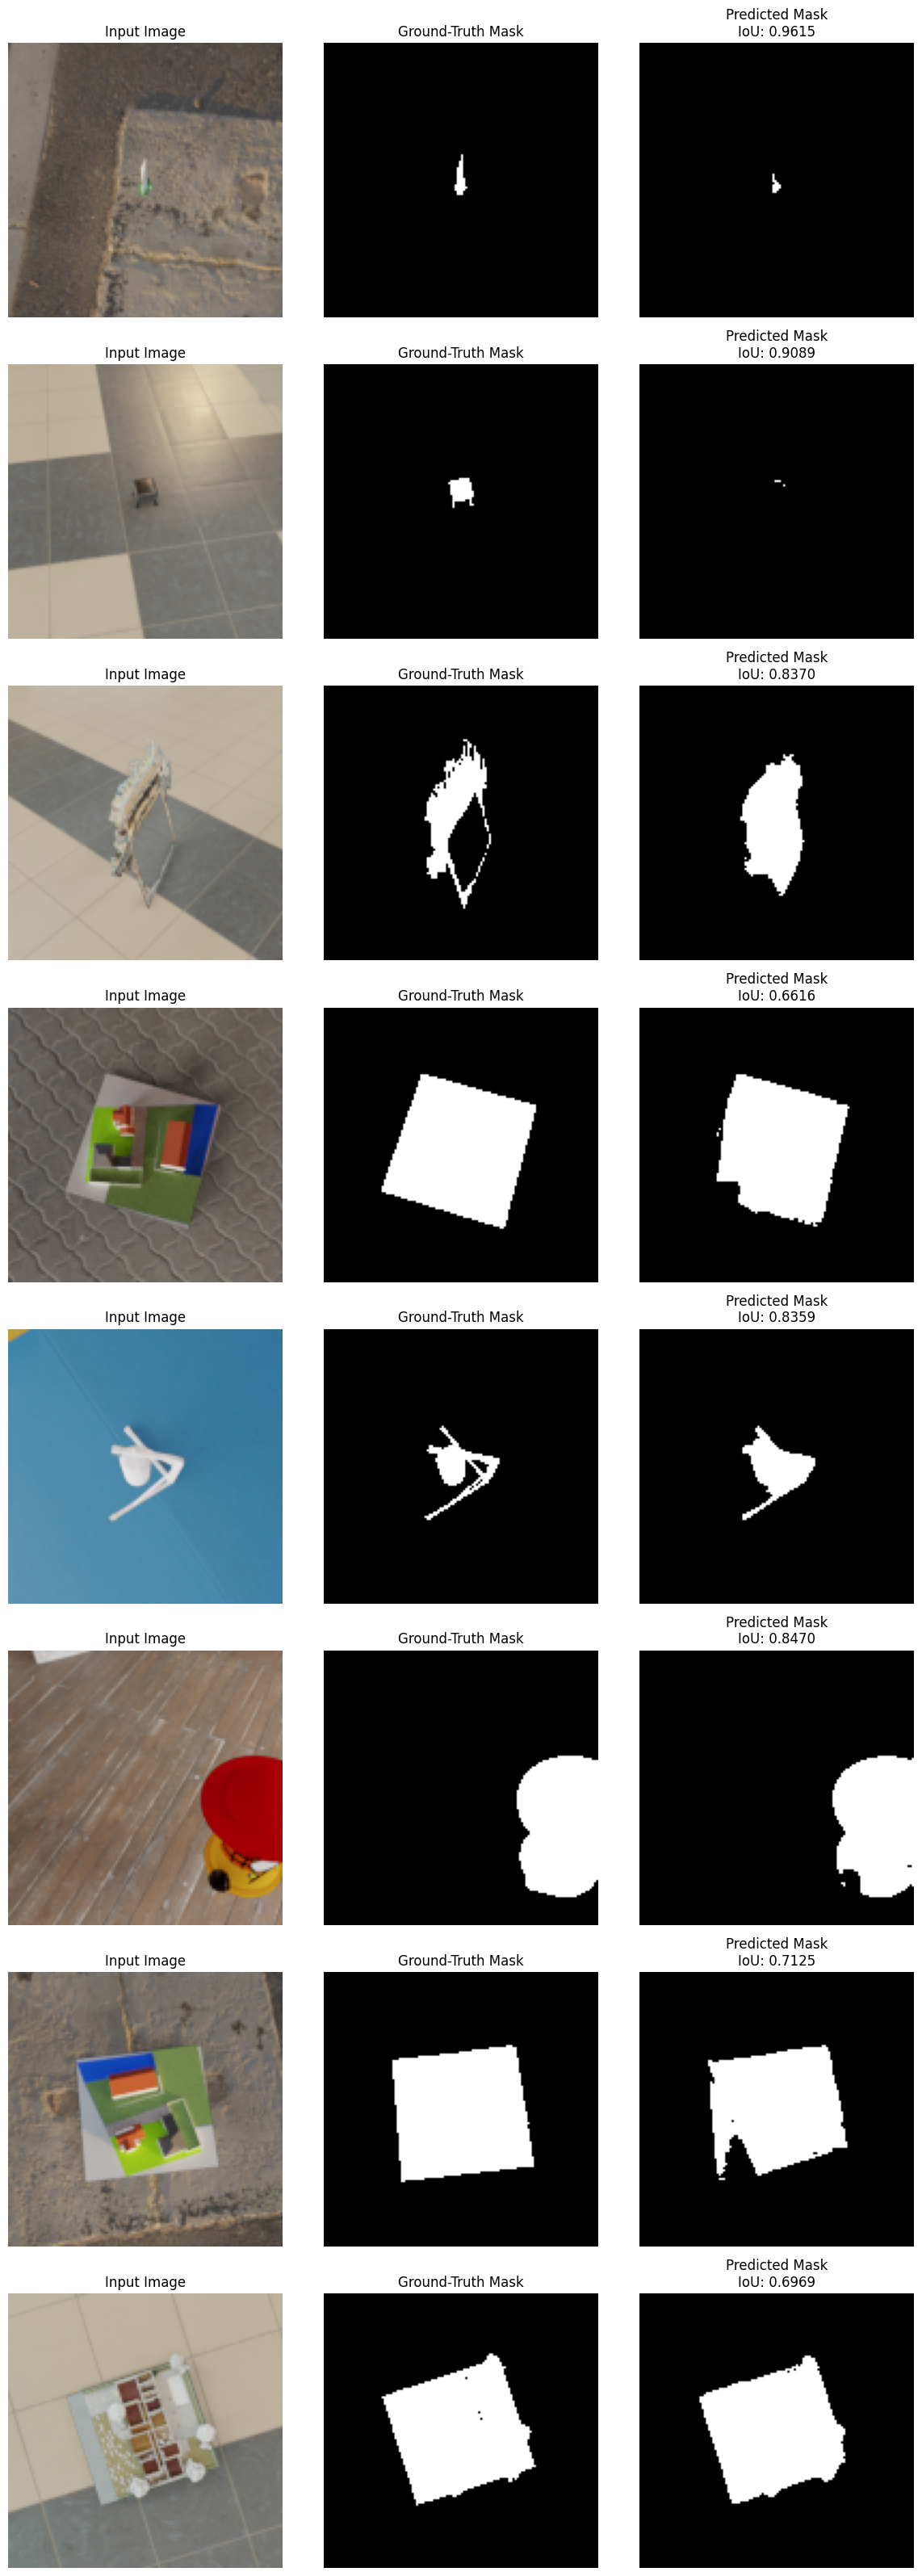

In [ ]:
def visualize_predictions(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)
    model.eval()
    total_iou = 0
    num_samples = 0  # To calculate average IoU later

    with torch.no_grad():
        images, masks = next(iter(dataloader))  # Get a single batch
        images, masks = images.to(device), masks.to(device)

        preds = model(images)
        preds_binary = (preds > 0.5).float()  # Threshold predictions

        # IoU for each image/mask pair
        individual_ious = []
        for i in range(len(images)):
            iou = calculate_iou(preds_binary[i].unsqueeze(0), masks[i].unsqueeze(0))
            individual_ious.append(iou.item())
            print(f"Sample {i + 1} IoU: {iou:.4f}")

        # Average IoU
        avg_iou = sum(individual_ious) / len(individual_ious)
        print(f"Average IoU for batch: {avg_iou:.4f}")

        # Plot the first few examples
        num_examples = min(8, len(images))  # Limit to 8 examples
        fig, axes = plt.subplots(num_examples, 3, figsize=(12, 4 * num_examples))

        for i in range(num_examples):
            axes[i, 0].imshow(images[i].cpu().permute(1, 2, 0))  # Input image
            axes[i, 0].set_title("Input Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(masks[i].cpu().squeeze(), cmap="gray")  # Ground-truth mask
            axes[i, 1].set_title("Ground-Truth Mask")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(preds_binary[i].cpu().squeeze(), cmap="gray")  # Predicted mask
            axes[i, 2].set_title(f"Predicted Mask\nIoU: {individual_ious[i]:.4f}")
            axes[i, 2].axis("off")

        plt.tight_layout()
        plt.show()

# Visualize predictions
visualize_predictions(model, test_dataloader)
